# Import Necessary Library

In [ ]:
import random
import copy
import time
import numpy as np
import gc
import re
import torch

#import spacy
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

tqdm.pandas(desc='Progress')
from collections import Counter

from nltk import word_tokenize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from sklearn.metrics import f1_score
import os

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer

from sklearn.preprocessing import StandardScaler
from multiprocessing import  Pool
from functools import partial
import numpy as np
from sklearn.decomposition import PCA
import torch as t
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

initialize variables which needs to embedding matrix and model

In [ ]:
embed_size = 300 # how big is each word vector
max_features = 120000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 750 # max number of words in a question to use
batch_size = 64 # how many samples to process at once
n_epochs = 4 # how many times to iterate over all samples
n_splits = 100 # Number of K-fold Splits
SEED = 10
debug = 0

Read resume data

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Nlp/Resume.csv")
data

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR
...,...,...,...,...
2479,99416532,RANK: SGT/E-5 NON- COMMISSIONED OFFIC...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION
2480,24589765,"GOVERNMENT RELATIONS, COMMUNICATIONS ...","<div class=""fontsize fontface vmargins hmargin...",AVIATION
2481,31605080,GEEK SQUAD AGENT Professional...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION
2482,21190805,PROGRAM DIRECTOR / OFFICE MANAGER ...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION


Drop Resume_html column. beacause it is not used our training session

In [ ]:
data = data.drop(['Resume_html'], axis=1)
data.head()

,ID,Resume_str,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,33176873,HR DIRECTOR Summary Over 2...,HR
3,27018550,HR SPECIALIST Summary Dedica...,HR
4,17812897,HR MANAGER Skill Highlights ...,HR


Chack our dataset have any null value or not

In [ ]:
data.isnull().any()

ID            False
Resume_str    False
Category      False
dtype: bool

get every datapoint length and save it in our new column 'len'

In [ ]:
data['len'] = data['Resume_str'].apply(lambda s : len(s))
data.head()

,ID,Resume_str,Category,len
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR,5442
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR,5572
2,33176873,HR DIRECTOR Summary Over 2...,HR,7720
3,27018550,HR SPECIALIST Summary Dedica...,HR,2855
4,17812897,HR MANAGER Skill Highlights ...,HR,9172


Draw a Histrogram for dataframe 'len' colum

<Axes: ylabel='Frequency'>

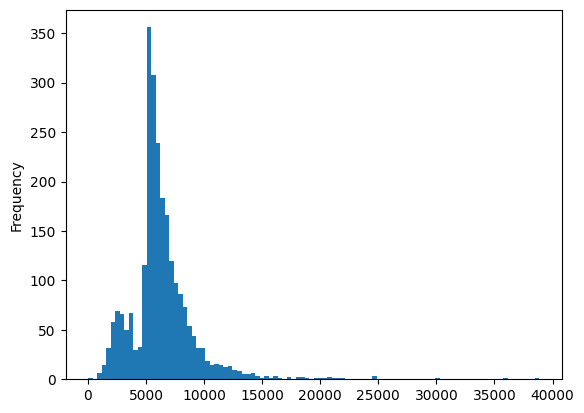

In [ ]:
data['len'].plot.hist(bins=100)

group by the category column and count the resume

In [ ]:
count_df = data[['Category','Resume_str']].groupby('Category').aggregate({'Resume_str':'count'}).reset_index().sort_values('Resume_str',ascending=False)
count_df.head()

,Category,Resume_str
20,INFORMATION-TECHNOLOGY,120
9,BUSINESS-DEVELOPMENT,120
0,ACCOUNTANT,118
1,ADVOCATE,118
16,FINANCE,118


In [ ]:
count_df['Resume_str'].max(),count_df['Resume_str'].min()

(120, 22)

Get all target value

In [ ]:
target_conditions = count_df[count_df['Resume_str']>20]['Category'].values
target_conditions,len(target_conditions)

(array(['INFORMATION-TECHNOLOGY', 'BUSINESS-DEVELOPMENT', 'ACCOUNTANT',
        'ADVOCATE', 'FINANCE', 'ENGINEERING', 'CHEF', 'FITNESS',
        'AVIATION', 'SALES', 'HEALTHCARE', 'CONSULTANT', 'BANKING',
        'CONSTRUCTION', 'PUBLIC-RELATIONS', 'HR', 'DESIGNER', 'ARTS',
        'TEACHER', 'APPAREL', 'DIGITAL-MEDIA', 'AGRICULTURE', 'AUTOMOBILE',
        'BPO'], dtype=object),
 24)

In [ ]:
def condition_parser(x):
    if x in target_conditions:
        return x
    else:
        return "OTHER"

data['Category'] = data['Category'].apply(lambda x: condition_parser(x))
data.head()

,ID,Resume_str,Category,len
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR,5442
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR,5572
2,33176873,HR DIRECTOR Summary Over 2...,HR,7720
3,27018550,HR SPECIALIST Summary Dedica...,HR,2855
4,17812897,HR MANAGER Skill Highlights ...,HR,9172


In [ ]:
data

,ID,Resume_str,Category,len
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR,5442
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR,5572
2,33176873,HR DIRECTOR Summary Over 2...,HR,7720
3,27018550,HR SPECIALIST Summary Dedica...,HR,2855
4,17812897,HR MANAGER Skill Highlights ...,HR,9172
...,...,...,...,...
2479,99416532,RANK: SGT/E-5 NON- COMMISSIONED OFFIC...,AVIATION,5533
2480,24589765,"GOVERNMENT RELATIONS, COMMUNICATIONS ...",AVIATION,7108
2481,31605080,GEEK SQUAD AGENT Professional...,AVIATION,2020
2482,21190805,PROGRAM DIRECTOR / OFFICE MANAGER ...,AVIATION,5074


ploting counted resume and see a barchart

In [ ]:
import plotly.express as px
px.bar(count_df[count_df['Resume_str']>20],x='Category',y='Resume_str')

In [ ]:
import re
def cleanResume(resumeText):
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText) # remove non-ascii characters
    resumeText = re.sub('\s+', ' ', resumeText)  # remove extra whitespace
    resumeText = re.sub(r'[0-9]+', '', resumeText)  #remove numbers
    return resumeText.lower()

Clean our unnecessary punctuations,non-ascii,extra whitespace,remove numbers  'Resume_str' column data . This is helped totraining the word embedding

In [ ]:
data["Resume_str"] = data["Resume_str"].apply(lambda x: cleanResume(x))
data

,ID,Resume_str,Category,len
0,16852973,hr administrator marketing associate hr admin...,HR,5442
1,22323967,hr specialist us hr operations summary versat...,HR,5572
2,33176873,hr director summary over years experience in...,HR,7720
3,27018550,hr specialist summary dedicated driven and dy...,HR,2855
4,17812897,hr manager skill highlights hr skills hr depa...,HR,9172
...,...,...,...,...
2479,99416532,rank sgt e non commissioned officer in charg...,AVIATION,5533
2480,24589765,government relations communications and organ...,AVIATION,7108
2481,31605080,geek squad agent professional profile it supp...,AVIATION,2020
2482,21190805,program director office manager summary highl...,AVIATION,5074


In [ ]:
data['Category'].unique(), len(data['Category'].unique())

(array(['HR', 'DESIGNER', 'INFORMATION-TECHNOLOGY', 'TEACHER', 'ADVOCATE',
        'BUSINESS-DEVELOPMENT', 'HEALTHCARE', 'FITNESS', 'AGRICULTURE',
        'BPO', 'SALES', 'CONSULTANT', 'DIGITAL-MEDIA', 'AUTOMOBILE',
        'CHEF', 'FINANCE', 'APPAREL', 'ENGINEERING', 'ACCOUNTANT',
        'CONSTRUCTION', 'PUBLIC-RELATIONS', 'BANKING', 'ARTS', 'AVIATION'],
       dtype=object),
 24)

divide 75% data is training and 25% data for test.

In [ ]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data['Resume_str'], data['Category'],
                                                    stratify=data['Category'],
                                                    test_size=0.25)

In [ ]:
print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (1863,)
Test shape :  (621,)


tokenizer is a utility function that splits a sentence into words. I am using keras.preprocessing.text.Tokenizer tokenizes. This is splits a text into tokens (words) while keeping only the words that occur the most in the text corpus

In [ ]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)
train_X

array([[    0,     0,     0, ...,    27,   108,  1156],
       [    3,   112,  2995, ..., 20124,  5148,  6131],
       [ 2351,    18,   114, ...,  1880,     1,    23],
       ...,
       [    0,     0,     0, ...,    12,   933,  4167],
       [    0,     0,     0, ...,     2,  1161,  9313],
       [    0,     0,     0, ...,   806,    50,   461]], dtype=int32)

In [ ]:
tokenizer

save it in a pickel file for using test session

In [ ]:
import pickle

# saving
with open('/content/drive/MyDrive/Colab Notebooks/Nlp/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

The Pytorch model expects the target variable as a number and not a string. We can use Label encoder from sklearn to convert our target variable

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

In [ ]:
le

LabelEncoder()

save it in a pickel file for using test session

In [ ]:
# saving
with open('/content/drive/MyDrive/Colab Notebooks/Nlp/le.pickle', 'wb') as handle:
    pickle.dump(le, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
le.classes_

array(['ACCOUNTANT', 'ADVOCATE', 'AGRICULTURE', 'APPAREL', 'ARTS',
       'AUTOMOBILE', 'AVIATION', 'BANKING', 'BPO', 'BUSINESS-DEVELOPMENT',
       'CHEF', 'CONSTRUCTION', 'CONSULTANT', 'DESIGNER', 'DIGITAL-MEDIA',
       'ENGINEERING', 'FINANCE', 'FITNESS', 'HEALTHCARE', 'HR',
       'INFORMATION-TECHNOLOGY', 'PUBLIC-RELATIONS', 'SALES', 'TEACHER'],
      dtype=object)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Load Embedding
The embeddings of words that are in our word_index, we will create a matrix that just contains required embeddings using the word index from our tokenizer.

In [ ]:
def load_glove(word_index):
    EMBEDDING_FILE = '/content/drive/MyDrive/Colab Notebooks/Nlp/glove.6B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [ ]:
embedding_matrix = load_glove(tokenizer.word_index)
np.shape(embedding_matrix)

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



(32838, 300)

save it in a pickel file for using test session

In [ ]:
# saving
with open('/content/drive/MyDrive/Colab Notebooks/Nlp/embedding_matrix.pickle', 'wb') as handle:
    pickle.dump(embedding_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

Impleament a model class which is inherit torch nn module and overwrite the forward method

In [ ]:
class BiLSTM(nn.Module):

    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 128
        drp = 0.5
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        #rint(x.size())
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

Intilize optimizer and loss function and train it 40 epochs

In [ ]:
n_epochs = 40
model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

#Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)

    # Set model to validation configuration -Doesn't get trained here
    model.eval()
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))

    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()

    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

<ipython-input-32-dadeb662f500>:48: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Epoch 1/40 	 loss=196.6898 	 val_loss=194.6065  	 val_acc=0.0853  	 time=2.99s
Epoch 2/40 	 loss=193.4519 	 val_loss=190.3224  	 val_acc=0.1320  	 time=1.88s
Epoch 3/40 	 loss=186.1054 	 val_loss=180.9461  	 val_acc=0.1594  	 time=1.90s
Epoch 4/40 	 loss=179.1484 	 val_loss=169.6183  	 val_acc=0.2576  	 time=1.97s
Epoch 5/40 	 loss=168.1936 	 val_loss=159.6476  	 val_acc=0.2721  	 time=1.95s
Epoch 6/40 	 loss=160.1277 	 val_loss=153.0882  	 val_acc=0.2625  	 time=1.97s
Epoch 7/40 	 loss=153.6325 	 val_loss=147.1669  	 val_acc=0.2802  	 time=1.97s
Epoch 8/40 	 loss=149.3796 	 val_loss=143.9901  	 val_acc=0.3172  	 time=1.97s
Epoch 9/40 	 loss=144.0983 	 val_loss=137.4869  	 val_acc=0.3768  	 time=1.99s
Epoch 10/40 	 loss=138.7340 	 val_loss=133.8080  	 val_acc=0.3800  	 time=1.97s
Epoch 11/40 	 loss=133.7322 	 val_loss=130.5704  	 val_acc=0.3881  	 time=1.99s
Epoch 12/40 	 loss=130.4432 	 val_loss=127.1901  	 val_acc=0.4187  	 time=1.98s
Epoch 13/40 	 loss=123.9457 	 val_loss=121.4310  

In [ ]:
torch.save(model,'/content/drive/MyDrive/Colab Notebooks/Nlp/BiLSTM')

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Nlp/modelcpu.pth')

Train vs validation loss graph function

In [ ]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

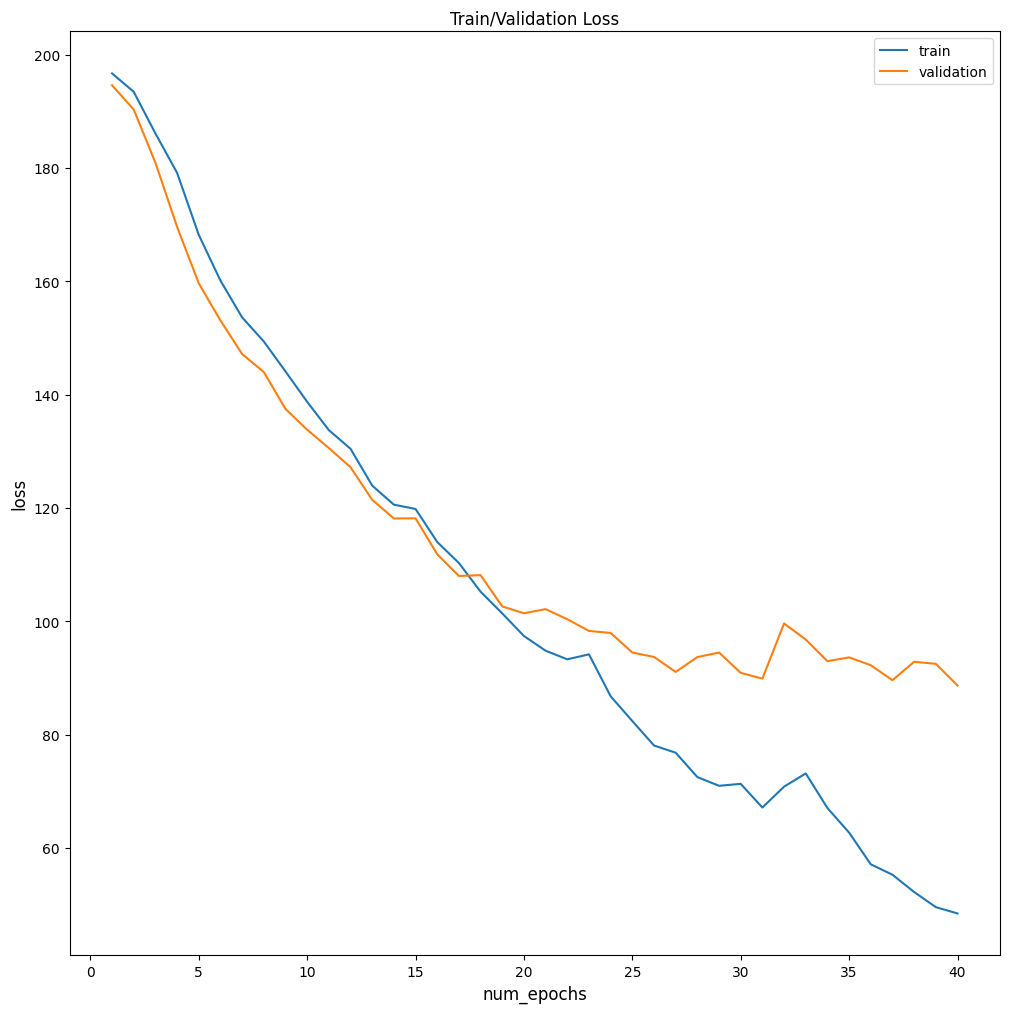

In [ ]:
plot_graph(n_epochs)

In [ ]:
!pip install scikit-plot

Confusion metrix for all classes

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

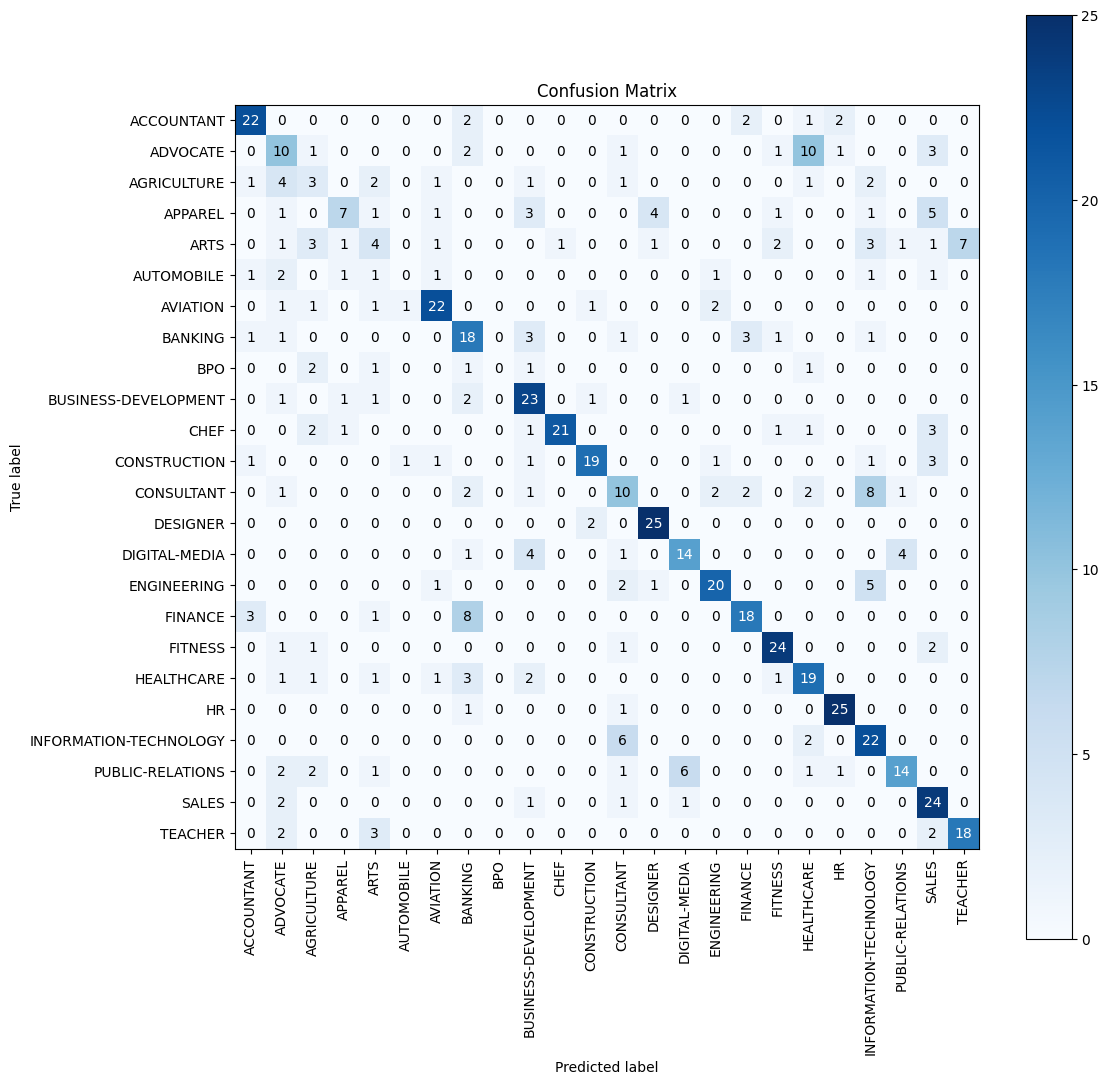

In [ ]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true,
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

In [ ]:
def predict_single(x):
    x = x.lower()
    x = cleanResume(x)
    x = tokenizer.texts_to_sequences([x])
    x = pad_sequences(x, maxlen=maxlen)
    x = torch.tensor(x, dtype=torch.long).cuda()
    pred = model(x).detach()
    pred = F.softmax(pred).cpu().numpy()
    pred = pred.argmax(axis=1)
    pred = le.classes_[pred]
    return pred[0]

In [ ]:
x = data['Resume_str'].values[20]
print(x)

 hr generalist summary young dedicated and focused office administrative assistant who excels at prioritizing completing multiple tasks simultaneously and following through to achieve project goals seeking a role of increased responsibility and authority skill highlights microsoft office proficiency self directed excel spreadsheets professional and mature meticulous attention to detail strong interpersonal skills results oriented keen understanding of grammar strong problem solver dedicated team player executive presentation development ability to maintain confidentiality accomplishments received a merit raise for strong attention to detail exemplary customer service and team player attitude extra mile award   increased office organization by developing more efficient filing system and customer database protocols experience hr generalist april  to october  company name city state served as central point of contact for employee relations matters processed onboarding and new hire paperwo

In [ ]:
predict_single(x)

<ipython-input-39-fb063c0413cd>:19: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



'HR'

Predict unknown data

In [ ]:
text = """ASSISTANT TEACHER
Summary
Teacher's Aide who has lovingly taught 8 children,ages 0 through 18 months. Thorough in guiding children through a variety of daily activitiesand
making surethecurriculumisage-appropriateand fun. Dependableand reliable worked others shifts when they couldn'tmakeit to work.
Highlights
Charting and recordkeeping
Child abuse prevention
Understands developmental disorders
Activelistener
Firstaid certificate
Basicclerical knowledge
Reliableand punctual
Friendly
Cheerfuland energetic
Teamwork oriented
Housekeeping
Experience
Assistant Teacher
November 2014 to October 2015 CompanyNameï¼ City , State
Assistant TeacherSanitized alltoysand play areas daily.
Maintained asafe,clean and constantly supervised play environment.
Supported children'semotionaland social development with one-on-oneattention.
Prepared, served and cleaned up dailymeals for 8 children.
Used read-aloud timeand alphabet games to promoteearly literacy.
Used clearcommunication and professionalismto develop constructiverelationships with families.
Clearly communicated to children in developmentally appropriate way.
Carefully supervised children in play area.
Instructed children in health and personal habits including eating, resting and toilet habits.
Cashier, Hostess, Salad Bar Person
November 2006 to January 2009 CompanyNameï¼ City , State
Accepted payment fromcustomersand madechangeas necessary.
Assisted diners with seating as needed
Assisted co-workers.
Cleaned and prepared various foods forcooking or serving
Cleaned bars, work areas,and tables
Cleaned and maintained the beveragearea, display cases,equipment,and order transaction area
Cleaned up spilled food, drink and broken dishes,and removed empty bottlesand trash
Greeted customers in therestaurant or drive-thru, took and rang up orders, handled paymentand thanked customers
Performed serving,cleaning,and stocking duties in establishments
Prepared coffee-based and other beverages on request;serve prepared pastriesand other food items
Used allfood handling standards
Washed, peeled,cut,and seeded fruitsand vegetables
Compiled and maintained records offood useand expenditures
Prepared the buffetand salad bar for dinner service.
Continually keptcarpetsand floorclear of debris.
Received frequentcustomercompliments for going aboveand beyond normal duties.
Cashier, Hostess, Salad Bar Person
July 2004 to September 2006 CompanyNameï¼ City , State
Accepted payment fromcustomersand madechangeas necessary.
Assisted co-workers.
Assisted diners with seating as needed
Cleaned and maintained the beveragearea, display cases,equipment,and order transaction area
Cleaned and prepared various foods forcooking or serving
Cleaned bars, work areas,and tables
Cleaned up spilled food, drink and broken dishes,and removed empty bottlesand trash
Greeted customers in therestaurant or drive-thru, took and rang up orders, handled paymentand thanked customers
Greeted guestsand sat themat tables or inwaiting areas
Kept drink stationsclean and ready for service
Prepared coffee-based and other beverages on request;serve prepared pastriesand other food items
Prepared food items such as sandwiches, salads, soups,and beverages
Stocked supplies in serving stations,cupboards, refrigerators,and salad bars
Stored clean equipmentand utensils
Used allfood handling standards
Washed, peeled,cut,and seeded fruitsand vegetables
Communicated with customers regarding orders,comments,and complaints
Compiled and maintained records offood useand expenditures
Provided customers with product details, such ascoffee blend and preparation descriptions
Prepared the buffetand salad bar for dinner service.
Continually keptcarpetsand floorclear of debris.
Maintained a professionaltoneatalltimes, including during peak rush hours.
Received frequentcustomercompliments for going aboveand beyond normal duties.
Owner, receptionist, Sales
April 2001 to December 2003 CompanyNameï¼ City , State
Managed thereceptionistarea, including greeting visitorsand responding to telephoneand in-person requests for information.
Maintained thefront desk and reception areain a neatand organized fashion.
Madecopies, sent faxesand handled allincoming and outgoing correspondence.
Issued 8 paychecks to vendorsand suppliers on a bi-weekly basis.
Handled cash and deposits using the properaccounting proceduresand documentation.
3years of officeexperience.
Addressed negativecustomer feedback immediately.Kept records ofroomavailability and guests' accounts, manually or using computers.
Kept records ofroomavailability and guests' accounts, manually or using computers.
Monitored daily banking transactions. Worked quickly and efficiently, withminimal oversight, to accomplish assigned duties.
Recommended and helped customers selectmerchandise based on their needs.
Exchanged returned merchandiseforcustomers quickly and efficiently.
Opened and closed thestore, including counting cash, opening and closing cash registersand creating staffassignments
.Demonstrated thatcustomerscomefirst by serving themwith asense of urgency.
Maintained friendly and professionalcustomer interactions. Worked asateammember to providethe highest level ofserviceto customers.
Education
Associate ofScience:Computer Information Science AS , 2017 Everest UniversityOnlineï¼ City , State, US
Recipient ofZenithGrant,
SocialWork University ofNorthDakotaï¼ City , State
I got Creditsand I finished most ofmyLiberals 08/2012 - 05/2014 I did alot ofclasses for SocialWork
Business Northland Community and TechnicalCollegeï¼ City , State
I took alot ofclasses for Office Assistantand did Liberals too. 08/2008 - 05/2014
Skills
Peopleskills
enthusiastic people person,
problem-solving
organizationalskill"""

In [ ]:
predict_single(text)

<ipython-input-39-fb063c0413cd>:19: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



'TEACHER'